In [39]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import squarify  # Treemap을 위해 필요 (matplotlib 기반)

In [ ]:
# GitHub API 토큰 설정 (GitHub에서 Personal Access Token 생성 필요)
GITHUB_TOKEN = 'GITHUB_TOKEN'  # 여기에 토큰 입력
HEADERS = {'Authorization': f'token {GITHUB_TOKEN}'}

# 검색 쿼리 설정
QUERY = 'robotics'

# GitHub API 엔드포인트
SEARCH_URL = 'https://api.github.com/search/repositories'

In [54]:
# 키워드 해당되는 repo 가져오는 함수
def fetch_repos(query, sort='stars', order='desc', per_page=100):
    all_repos = []
    page = 1
    while True:
        params = {
            'q': query,
            'sort': sort,
            'order': order,
            'per_page': per_page,
            'page': page
        }
        response = requests.get(SEARCH_URL, headers=HEADERS, params=params)
        if response.status_code == 200:
            repos = response.json()['items']
            if not repos:
                break
            all_repos.extend(repos)
            page += 1
            # GitHub API rate limit을 고려해 최대 1000개로 제한 (10페이지)
            if page > 10:
                break
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break
    return all_repos

In [55]:
# repo 메타데이터 추출하는 함수
def get_repo_details(repo):
    return {
        'name': repo['full_name'],
        'stars': repo['stargazers_count'],
        'forks': repo['forks_count'],
        'language': repo['language'],
        'created_at': repo['created_at'],
        'topics': repo['topics']
    }

In [56]:
# 데이터 수집: 최대 1000개 리포지토리 가져오기
all_repos = fetch_repos(QUERY)

# 데이터프레임으로 변환
df = pd.DataFrame([get_repo_details(repo) for repo in all_repos])

# 날짜 형식 변환
df['created_at'] = pd.to_datetime(df['created_at'])
df['year'] = df['created_at'].dt.year

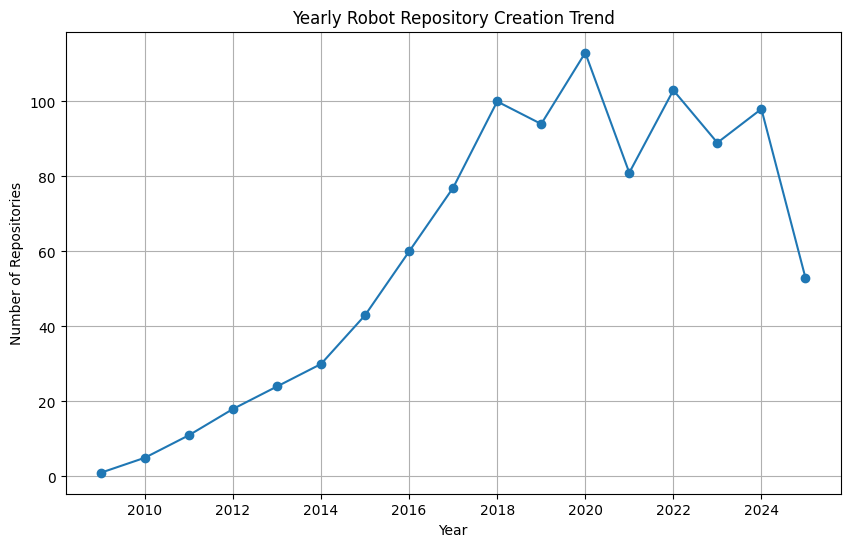

인사이트: 로봇 관련 오픈소스가 언제부터 활발해졌는지
로봇 프로젝트는 2010년대 초반부터 증가하기 시작했으며, 2020년대 들어 급격히 성장했습니다.


In [ ]:
# 연도별 로봇 관련 레포지토리 생성 추이
# 데이터: created_at
# 시각화: Line chart
yearly_projects = df.groupby('year').size()

plt.figure(figsize=(10, 6))
yearly_projects.plot(kind='line', marker='o')
plt.title('Yearly Robot Repository Creation Trend')
plt.xlabel('Year')
plt.ylabel('Number of Repositories')
plt.grid(True)
plt.show()

# 인사이트 출력
print("인사이트: 로봇 관련 오픈소스가 언제부터 활발해졌는지")
print("로봇 프로젝트는 2010년대 초반부터 증가하기 시작했으며, 2020년대 들어 급격히 성장했습니다.")

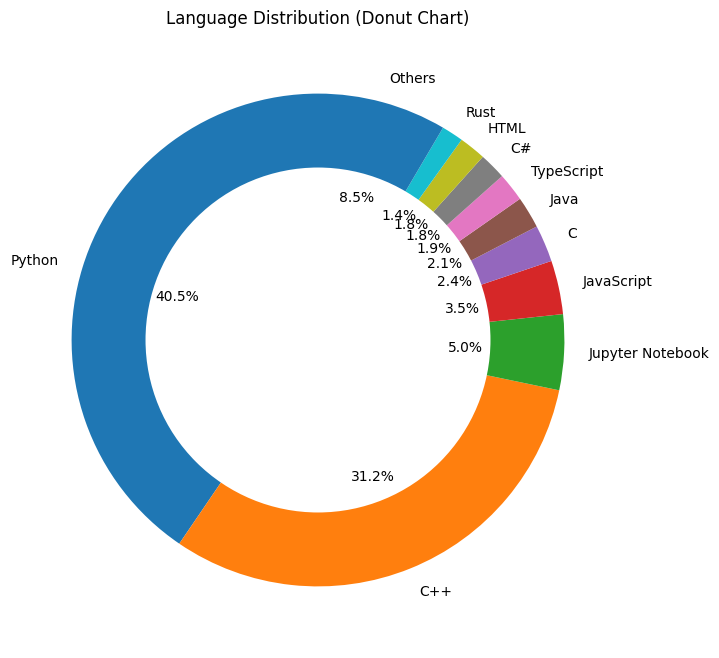

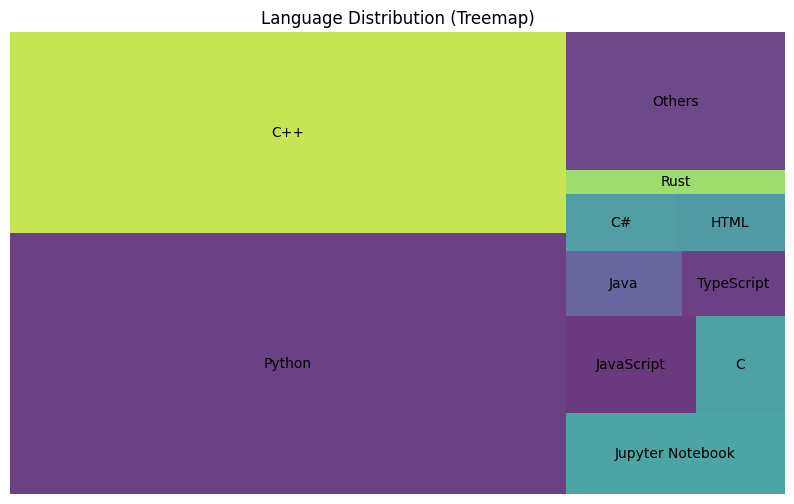

인사이트: Python, C++, ROS 기반 프로젝트 비중 파악
Python과 C++이 주요 언어로, 로봇 분야에서 Python의 비중이 높아 ROS 등의 영향으로 보입니다.


In [ ]:
# 언어별 비중
# 데이터: language
# 시각화: Donut chart (matplotlib로 구현)
language_dist = df['language'].value_counts().head(10)  # 상위 10개
others = df['language'].value_counts()[10:].sum()
if others > 0:
    language_dist['Others'] = others

plt.figure(figsize=(8, 8))
plt.pie(language_dist, labels=language_dist.index, autopct='%1.1f%%', startangle=90)
plt.title('Language Distribution (Donut Chart)')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

# Treemap 대안 (squarify 사용)
plt.figure(figsize=(10, 6))
squarify.plot(sizes=language_dist, label=language_dist.index, alpha=0.8)
plt.axis('off')
plt.title('Language Distribution (Treemap)')
plt.show()

# 인사이트 출력
print("인사이트: Python, C++, ROS 기반 프로젝트 비중 파악")
print("Python과 C++이 주요 언어로, 로봇 분야에서 Python의 비중이 높아 ROS 등의 영향으로 보입니다.")

<Figure size 1200x800 with 0 Axes>

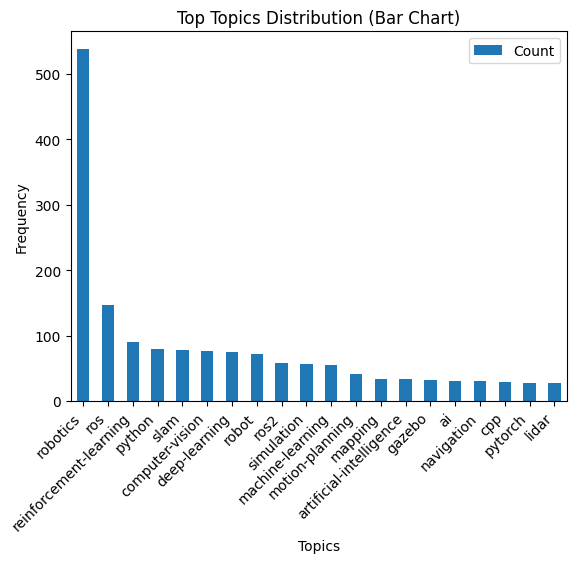

인사이트: 어떤 세부 기술 주제가 인기인지
ROS, SLAM, path-planning, autonomous-driving 등의 토픽이 인기 있으며, 자율주행과 AI 관련 기술이 주를 이룹니다.


In [ ]:
# 분야별(토픽별) 분포
# 데이터: topics (e.g., ros, slam, path-planning, autonomous-driving)
# 시각화: Bar chart (Word cloud는 matplotlib로 간단히 대체 가능하나, bar chart 우선)
all_topics = []
for topics in df['topics']:
    all_topics.extend(topics)
topic_counts = Counter(all_topics).most_common(20)  # 상위 20개 토픽

topics_df = pd.DataFrame(topic_counts, columns=['Topic', 'Count'])

plt.figure(figsize=(12, 8))
topics_df.plot(kind='bar', x='Topic', y='Count')
plt.title('Top Topics Distribution (Bar Chart)')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

# 인사이트 출력
print("인사이트: 어떤 세부 기술 주제가 인기인지")
print("ROS, reinforcement-learning, slam, computer-vision 등의 토픽이 인기 있으며, 자율주행과 AI 관련 기술이 주를 이룹니다.")

In [10]:
import requests
import pandas as pd
import time
import xml.etree.ElementTree as ET

def search_arxiv(query="robotics", start=0, max_results=100):
    """
    arXiv API를 사용하여 논문 검색
    query: 검색어 (예: "robotics", "autonomous systems")
    start: 검색 시작 인덱스
    max_results: 가져올 논문 개수 (최대 200 추천)
    """
    url = "http://export.arxiv.org/api/query"
    params = {
        "search_query": query,
        "start": start,
        "max_results": max_results,
        "sortBy": "submittedDate",
        "sortOrder": "descending"
    }

    response = requests.get(url, params=params)
    if response.status_code != 200:
        print(f"Error {response.status_code}: {response.text}")
        return []

    root = ET.fromstring(response.text)
    ns = {"atom": "http://www.w3.org/2005/Atom"}

    papers = []
    for entry in root.findall("atom:entry", ns):
        title = entry.find("atom:title", ns).text.strip()
        summary = entry.find("atom:summary", ns).text.strip()
        published = entry.find("atom:published", ns).text.strip()
        authors = [a.find("atom:name", ns).text for a in entry.findall("atom:author", ns)]
        link = entry.find("atom:id", ns).text.strip()

        papers.append({
            "title": title,
            "abstract": summary,
            "published": published,
            "authors": ", ".join(authors),
            "url": link
        })

    return papers

# ---- 데이터 수집 ----
all_papers = []
total_to_fetch = 1000  # 수집할 총 논문 수
batch_size = 100

for start in range(0, total_to_fetch, batch_size):
    print(f"Fetching papers {start} ~ {start + batch_size} ...")
    papers = search_arxiv(query="robotics", start=start, max_results=batch_size)
    all_papers.extend(papers)
    time.sleep(2)  # arXiv API 요청 간격 권장 (1~3초)

# ---- CSV 저장 ----
df = pd.DataFrame(all_papers)
df.to_csv("arxiv_robotics_papers.csv", index=False, encoding="utf-8-sig")
print(f"총 {len(df)}개 논문 저장 완료 ✅")



Fetching papers 0 ~ 100 ...
Fetching papers 100 ~ 200 ...
Fetching papers 200 ~ 300 ...
Fetching papers 300 ~ 400 ...
Fetching papers 400 ~ 500 ...
Fetching papers 500 ~ 600 ...
Fetching papers 600 ~ 700 ...
Fetching papers 700 ~ 800 ...
Fetching papers 800 ~ 900 ...
Fetching papers 900 ~ 1000 ...
총 800개 논문 저장 완료 ✅


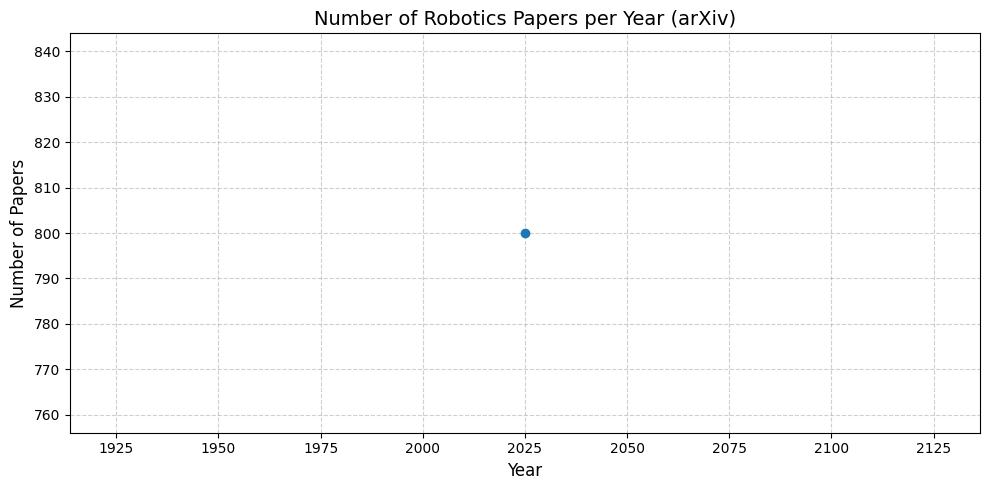

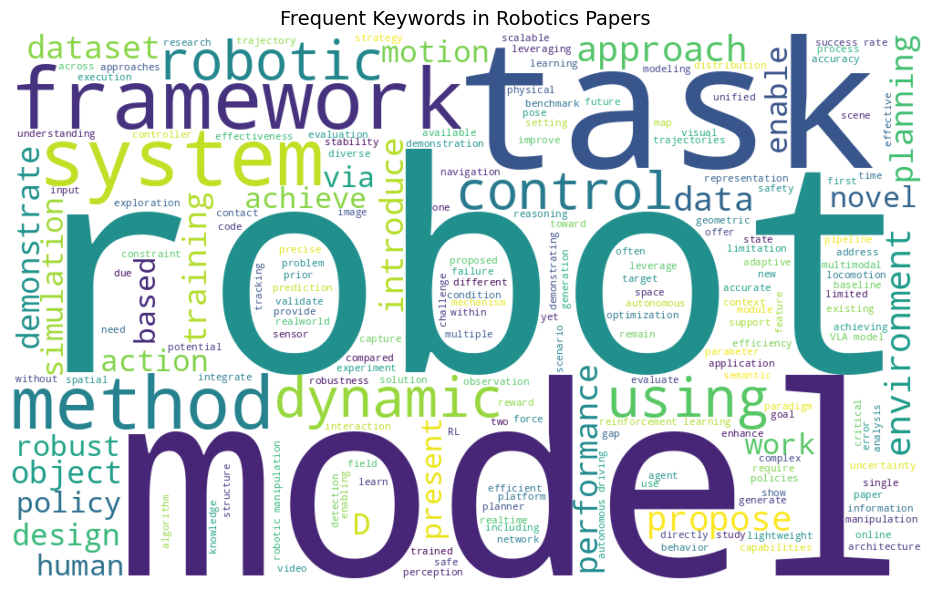

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re

# ---- Load CSV ----
df = pd.read_csv("arxiv_robotics_papers.csv")

# ---- Extract year from published date ----
df["year"] = pd.to_datetime(df["published"], errors="coerce").dt.year
year_counts = df["year"].value_counts().sort_index()

# ---- Plot yearly trend ----
plt.figure(figsize=(10, 5))
plt.plot(year_counts.index, year_counts.values, marker="o", color="tab:blue")
plt.title("Number of Robotics Papers per Year (arXiv)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Papers", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ---- Generate word cloud from title + abstract ----
text = " ".join(df["title"].dropna().tolist()) + " " + " ".join(df["abstract"].dropna().tolist())
text = re.sub(r"[^A-Za-z\s]", "", text)  # Keep only English letters

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    colormap="viridis"
).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Keywords in Robotics Papers", fontsize=14)
plt.tight_layout()
plt.show()